<a href="https://colab.research.google.com/github/mwl10/hetvae/blob/errors/src/catalina_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import shutil
os.chdir('/content')
! git clone --branch errors https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import optuna
from optuna.trial import TrialState
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import my_utils
import pandas as pd
from glob import glob
import importlib
import vae_models
import matplotlib.pyplot as plt
import sys
from dataset import DataSet
%matplotlib inline

fatal: destination path 'hetvae' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
def define_model_args(trial):

    args = Namespace(
        batch_size = 8, #trial.suggest_categorical("batch_size", [8,16,32]),
        bound_variance = True,
        const_var = False,
        dataset='toy',
        dropout = 0.3,#trial.suggest_float("dropout", 0.0,0.5),
        elbo_weight = 1,#trial.suggest_float("elbo_weight", 0.0, 2.0),
        embed_time = 32, #trial.suggest_categorical("embed_time", [8,16,32,64]),
        enc_num_heads=4,#trial.suggest_categorical("enc_num_heads", [1,2,4,8]),
        intensity=True,
        k_iwae=1,
        kl_annealing=False,#trial.suggest_categorical("kl_annealing",False),
        kl_zero=False, 
        latent_dim=32,#trial.suggest_categorical("latent_dim", [8,16,32,64,128]),
        lr=trial.suggest_float("lr", 1e-7, 1e-1, log=True),
        mixing="concat_and_mix",#trial.suggest_categorical("mixing", ["concat", "concat_and_mix"]),#"separate", "interp_only", "na"]),
        mse_weight=4,#trial.suggest_float("mse_weight",1,6),
        #n=trial.suggest_categorical("n", [8,16,32,64,128]),
        net='hetvae', 
        niters=1000, 
        norm=True, 
        normalize_input='znorm', 
        num_ref_points=trial.suggest_categorical("num_ref_points", [64]),
        rec_hidden=32,#trial.suggest_categorical("rec_hidden", [16,32,64]),
        recon_loss=False, 
        sample_tp= 0.5,#trial.suggest_float("sample_tp", 0.1,0.9), # will be ignored
        save=False, 
        seed=0, 
        shuffle=True, 
        std=0.1, 
        var_per_dim=False, 
        width=128,#trial.suggest_categorical("width", [32,64,128])
    )

    return args

In [42]:
EPOCHS = 200
FILES = glob('/content/hetvae/data/CAT/*/*')
#FILES = glob('/content/hetvae/data/CAT/*/*')[:50]


DIM = 1

621
0.5096901962886006
585
0.7238968017976714
598
0.6490217293408855
82
0.3811101800439146
570
0.7443010199958523
created union_x attribute of length 2438
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (5, 619, 3), instead of a list of numpy arrays
619
1.5159873681382836
583
1.4847727117884144
598
1.4190949857376904
82
1.4474996290568654
566
1.600833701603984
created union_x attribute of length 2406
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (5, 613, 3), instead of a list of numpy arrays


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RankWarning:

Polyfit may be poorly conditioned

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RankWarning:

Polyfit may be poorly conditioned

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RankWarning:

Polyfit may be poorly conditioned

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RankWarning:

Polyfit may be poorly conditioned

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RankWarning:

Polyfit may be poorly conditioned

/content/hetvae/src/dataset.py:328: RuntimeWarning:

divide by zero encountered in true_divide

/content/hetvae/src/dataset.py:328: RuntimeWarning:

divide by zero encountered in true_divide



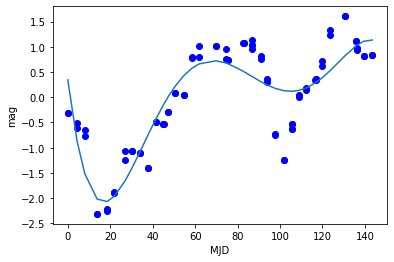

In [36]:
#------------------------------
# AGN Preprocessing, we have a DF w/ OBJECT , FILTER, MJD, FLUX, ERROR
#------------------------------

agn_df = pd.read_csv('/content/hetvae/data/AGN_1H2106-099/1H2106-099_latest_lcs_pyroa.csv')
# handle formatting for new AGN
lcs = []
for lc_df in agn_df.groupby('Filter'):
    lc = lc_df[1][['MJD', 'Flux', 'Error']].to_numpy()
    lcs.append(lc)
# lcs[0] = lcs[0][lcs[0][:,0].argsort()]
# lcs[0] = np.concatenate((lcs[0][:10], lcs[0][410:]))

# lcs = [lcs[0], lcs[0]]
AGN_1H2106 = DataSet()
AGN_1H2106.dataset = lcs # skip add files part

AGN_1H2106 = AGN_1H2106.handle_dups() \
                      .prune_graham() \
                      .normalize(normalize_y='individual', normalize_x='', x_by_range=False, y_by_range=False) \
                      .reorder() \
                      .set_union_x() \
                      .zero_fill() \
                      .error_to_sample_weight() \
                      .set_target_x()

union_x = AGN_1H2106.union_x
# lcs = [lcs[0], lcs[0]]
AGN_1H2106 = DataSet()
AGN_1H2106.dataset = lcs # skip add files part

AGN_1H2106 = AGN_1H2106.handle_dups() \
                      .prune_graham(plot=True, index=3) \
                      .normalize(normalize_y='individual', normalize_x='', x_by_range=False, y_by_range=False) \
                      .reorder() \
                      .set_union_x() \
                      .zero_fill() \
                      .error_to_sample_weight() \
                      .set_target_x()

AGN_1H2106.dataset = AGN_1H2106.dataset[3:4, :, :]


In [40]:
def objective(trial):

    args = define_model_args(trial)

    seed = args.seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # dataset hyperparams
    num_samples=trial.suggest_int("num_samples", 1,6)
    # normalize choices for optuna
    #x_by_range = trial.suggest_categorical("x_by_range", [True, False])
    #y_by_range = False #trial.suggest_categorical("y_by_range", [True, False])
    #normalize_y = trial.suggest_categorical("normalize_y", ["all", "individual"])

    # with suppress_stdout():
        # AGN = DataSet().add_files(FILES).files_to_numpy().handle_dups().prune_graham().resample_dataset(num_samples=num_samples) \
        #     .normalize(y_by_range=y_by_range, x_by_range=x_by_range).set_union_x().zero_fill().make_masks(frac=args.sample_tp)
        # AGN = DataSet()
        # AGN.dataset = lcs
        # AGN = AGN.handle_dups().prune_outliers().resample_dataset(num_samples=num_samples) \
        #      .normalize(y_by_range=y_by_range, x_by_range=x_by_range).set_union_x().zero_fill().make_masks(frac=args.sample_tp)



    LightCurves = AGN_1H2106.dataset

    training, valid = np.split(LightCurves, [int(np.floor(1*len(LightCurves)))])# shuffle?
    
    
    train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)
    
    
    net = models.load_network(args, DIM, torch.Tensor(union_x)) # , device="cuda"
    

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam"])
    optimizer = getattr(optim, optimizer_name)(net.parameters(), lr=args.lr)
    frac = 0.4#trial.suggest_float("sample_tp", 0.1,0.9)
    step_size = trial.suggest_categorical("step_size", [200,300,400,500])
    gamma = trial.suggest_float("gamma",0,1)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=gamma, step_size=step_size)
    for epoch in range(EPOCHS):
        nll_loss, mse = my_utils.train(net, optimizer, epoch, train_loader, args, device=device, frac=frac)
        #nll_loss = my_utils.evaluate(net, valid_loader, device=device)
        trial.report(nll_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return nll_loss

In [41]:
study = optuna.create_study(direction="minimize")

[I 2022-06-18 17:19:38,226] A new study created in memory with name: no-name-fb656849-bddb-46f1-8143-30f6d1547266


In [43]:
study.optimize(objective, n_trials=100, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 7630603096941068812288.0000, avg nll: 28.6859, avg kl: 43455097696509094789120.0000, mse: 821273331822539833344.000000, mae: 20778799104.000000


[I 2022-06-18 17:19:57,701] Trial 0 finished with value: 28.290420532226562 and parameters: {'lr': 0.03581213805122108, 'num_ref_points': 64, 'num_samples': 5, 'optimizer': 'Adam', 'step_size': 500, 'gamma': 0.736565043264766}. Best is trial 0 with value: 28.290420532226562.


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.6842, avg nll: 1.4478, avg kl: 0.0326, mse: 1.058294, mae: 0.883380


[I 2022-06-18 17:20:00,483] Trial 1 finished with value: 1.3962156772613525 and parameters: {'lr': 0.0001947302144606955, 'num_ref_points': 64, 'num_samples': 2, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.6946741755161243}. Best is trial 1 with value: 1.3962156772613525.


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.7222, avg nll: 1.4596, avg kl: 0.2291, mse: 1.059937, mae: 0.884916


[I 2022-06-18 17:20:03,289] Trial 2 finished with value: 1.395848274230957 and parameters: {'lr': 8.687490916039268e-05, 'num_ref_points': 64, 'num_samples': 5, 'optimizer': 'Adam', 'step_size': 200, 'gamma': 0.6252380833467578}. Best is trial 2 with value: 1.395848274230957.


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.8097, avg nll: 1.5116, avg kl: 0.5592, mse: 1.060559, mae: 0.885377


[I 2022-06-18 17:20:06,330] Trial 3 finished with value: 1.403290033340454 and parameters: {'lr': 3.522493798393125e-05, 'num_ref_points': 64, 'num_samples': 1, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.3137070638782514}. Best is trial 2 with value: 1.395848274230957.


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.9475, avg nll: 1.5948, avg kl: 1.1333, mse: 1.059844, mae: 0.884817


[I 2022-06-18 17:20:09,059] Trial 4 finished with value: 1.508107304573059 and parameters: {'lr': 2.041597962555303e-07, 'num_ref_points': 64, 'num_samples': 4, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.4657942761064101}. Best is trial 2 with value: 1.395848274230957.


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 2.0120, avg nll: 0.8988, avg kl: 0.1612, mse: 0.274256, mae: 0.437590


[I 2022-06-18 17:20:11,931] Trial 5 finished with value: 1.393331527709961 and parameters: {'lr': 0.008644732535820475, 'num_ref_points': 64, 'num_samples': 4, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.2485428911027886}. Best is trial 5 with value: 1.393331527709961.


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:20:12,333] Trial 6 pruned. 
[I 2022-06-18 17:20:12,371] Trial 7 pruned. 
[I 2022-06-18 17:20:12,407] Trial 8 pruned. 
[I 2022-06-18 17:20:12,468] Trial 9 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.6817, avg nll: 1.4485, avg kl: 0.0053, mse: 1.058169, mae: 0.882986


[I 2022-06-18 17:20:14,456] Trial 10 pruned. 
[I 2022-06-18 17:20:14,504] Trial 11 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.6814, avg nll: 1.4474, avg kl: 0.0173, mse: 1.058075, mae: 0.883202


[I 2022-06-18 17:20:16,492] Trial 12 pruned. 
[I 2022-06-18 17:20:16,540] Trial 13 pruned. 
[I 2022-06-18 17:20:16,587] Trial 14 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.6798, avg nll: 1.4478, avg kl: 0.0057, mse: 1.057850, mae: 0.883206


[I 2022-06-18 17:20:18,590] Trial 15 pruned. 
[I 2022-06-18 17:20:18,636] Trial 16 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.6775, avg nll: 1.4474, avg kl: 0.0118, mse: 1.057224, mae: 0.880858


[I 2022-06-18 17:20:20,441] Trial 17 pruned. 
[I 2022-06-18 17:20:20,487] Trial 18 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.7334, avg nll: 1.4655, avg kl: 0.2735, mse: 1.060125, mae: 0.885063


[I 2022-06-18 17:20:23,320] Trial 19 finished with value: 1.3954721689224243 and parameters: {'lr': 7.639951337788389e-05, 'num_ref_points': 64, 'num_samples': 4, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.17327120762691411}. Best is trial 5 with value: 1.393331527709961.


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 4.4036, avg nll: 1.3116, avg kl: 0.0889, mse: 0.770780, mae: 0.723641


[I 2022-06-18 17:20:26,128] Trial 20 finished with value: 1.1333051919937134 and parameters: {'lr': 0.0068004379751207674, 'num_ref_points': 64, 'num_samples': 2, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.19354687990555275}. Best is trial 20 with value: 1.1333051919937134.


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.7005, avg nll: 1.4486, avg kl: 0.0664, mse: 1.061301, mae: 0.880220


[I 2022-06-18 17:20:28,923] Trial 21 finished with value: 0.48337844014167786 and parameters: {'lr': 0.0053719722486693005, 'num_ref_points': 64, 'num_samples': 2, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.2034662137941385}. Best is trial 21 with value: 0.48337844014167786.


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 1.4500, avg nll: 0.7244, avg kl: 0.1858, mse: 0.176758, mae: 0.342746


[I 2022-06-18 17:20:31,816] Trial 22 finished with value: 0.1923220306634903 and parameters: {'lr': 0.006046054929901669, 'num_ref_points': 64, 'num_samples': 2, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.21908408512181488}. Best is trial 22 with value: 0.1923220306634903.


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:20:32,233] Trial 23 pruned. 
[I 2022-06-18 17:20:32,285] Trial 24 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.6857, avg nll: 1.4516, avg kl: 0.0054, mse: 1.058389, mae: 0.883707


[I 2022-06-18 17:20:34,108] Trial 25 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.6777, avg nll: 1.4470, avg kl: 0.0144, mse: 1.057316, mae: 0.880010


[I 2022-06-18 17:20:35,941] Trial 26 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 6.4125, avg nll: 1.7102, avg kl: 0.3490, mse: 1.166832, mae: 0.866850


[I 2022-06-18 17:20:38,785] Trial 27 finished with value: 1.4732799530029297 and parameters: {'lr': 0.010132072531292169, 'num_ref_points': 64, 'num_samples': 1, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.39575632262567056}. Best is trial 22 with value: 0.1923220306634903.


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:20:39,191] Trial 28 pruned. 
[I 2022-06-18 17:20:39,241] Trial 29 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.6800, avg nll: 1.4472, avg kl: 0.0139, mse: 1.057834, mae: 0.882891


[I 2022-06-18 17:20:41,240] Trial 30 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.5852, avg nll: 1.4494, avg kl: 0.2269, mse: 1.028257, mae: 0.866008


[I 2022-06-18 17:20:44,063] Trial 31 finished with value: 1.3974512815475464 and parameters: {'lr': 0.010277861630357578, 'num_ref_points': 64, 'num_samples': 2, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.2259394013268459}. Best is trial 22 with value: 0.1923220306634903.


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:20:44,472] Trial 32 pruned. 
[I 2022-06-18 17:20:44,521] Trial 33 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 3.6108, avg nll: 1.1704, avg kl: 0.6549, mse: 0.593724, mae: 0.592470


[I 2022-06-18 17:20:47,335] Trial 34 finished with value: 0.12629744410514832 and parameters: {'lr': 0.006572758547163779, 'num_ref_points': 64, 'num_samples': 1, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.2916186909269053}. Best is trial 34 with value: 0.12629744410514832.
[I 2022-06-18 17:20:47,385] Trial 35 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:20:47,802] Trial 36 pruned. 
[I 2022-06-18 17:20:47,849] Trial 37 pruned. 
[I 2022-06-18 17:20:47,898] Trial 38 pruned. 
[I 2022-06-18 17:20:47,945] Trial 39 pruned. 
[I 2022-06-18 17:20:47,993] Trial 40 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 4.6979, avg nll: 1.3454, avg kl: 0.1776, mse: 0.833666, mae: 0.784161


[I 2022-06-18 17:20:50,812] Trial 41 finished with value: 0.8987886309623718 and parameters: {'lr': 0.007218805713779099, 'num_ref_points': 64, 'num_samples': 4, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.28952968977137156}. Best is trial 34 with value: 0.12629744410514832.
[I 2022-06-18 17:20:50,863] Trial 42 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:20:51,269] Trial 43 pruned. 
[I 2022-06-18 17:20:51,319] Trial 44 pruned. 
[I 2022-06-18 17:20:51,368] Trial 45 pruned. 
[I 2022-06-18 17:20:51,418] Trial 46 pruned. 
[I 2022-06-18 17:20:51,467] Trial 47 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:20:51,517] Trial 48 pruned. 
[I 2022-06-18 17:20:51,567] Trial 49 pruned. 
[I 2022-06-18 17:20:51,614] Trial 50 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.5567, avg nll: 1.4165, avg kl: 0.0447, mse: 1.033935, mae: 0.843757


[I 2022-06-18 17:20:54,441] Trial 51 finished with value: 1.161017656326294 and parameters: {'lr': 0.007364500063651493, 'num_ref_points': 64, 'num_samples': 5, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.25796659695344387}. Best is trial 34 with value: 0.12629744410514832.


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.0213, avg nll: 1.4929, avg kl: 0.1098, mse: 0.879356, mae: 0.767910


[I 2022-06-18 17:20:57,268] Trial 52 finished with value: 1.1625545024871826 and parameters: {'lr': 0.00693046555749327, 'num_ref_points': 64, 'num_samples': 5, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.06772067624335662}. Best is trial 34 with value: 0.12629744410514832.
[I 2022-06-18 17:20:57,316] Trial 53 pruned. 
[I 2022-06-18 17:20:57,365] Trial 54 pruned. 
[I 2022-06-18 17:20:57,413] Trial 55 pruned. 
[I 2022-06-18 17:20:57,460] Trial 56 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:20:57,510] Trial 57 pruned. 
[I 2022-06-18 17:20:57,558] Trial 58 pruned. 
[I 2022-06-18 17:20:57,608] Trial 59 pruned. 
[I 2022-06-18 17:20:57,655] Trial 60 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:20:58,064] Trial 61 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.6934, avg nll: 1.4515, avg kl: 0.0259, mse: 1.059819, mae: 0.881905


[I 2022-06-18 17:21:00,994] Trial 62 finished with value: 1.4051718711853027 and parameters: {'lr': 0.007416694547656505, 'num_ref_points': 64, 'num_samples': 6, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.042211023836717876}. Best is trial 34 with value: 0.12629744410514832.
[I 2022-06-18 17:21:01,047] Trial 63 pruned. 
[I 2022-06-18 17:21:01,139] Trial 64 pruned. 
[I 2022-06-18 17:21:01,187] Trial 65 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:21:01,239] Trial 66 pruned. 
[I 2022-06-18 17:21:01,288] Trial 67 pruned. 
[I 2022-06-18 17:21:01,339] Trial 68 pruned. 
[I 2022-06-18 17:21:01,388] Trial 69 pruned. 
[I 2022-06-18 17:21:01,439] Trial 70 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.6916, avg nll: 1.4499, avg kl: 0.0469, mse: 1.059258, mae: 0.885062


[I 2022-06-18 17:21:03,255] Trial 71 pruned. 
[I 2022-06-18 17:21:03,306] Trial 72 pruned. 
[I 2022-06-18 17:21:03,355] Trial 73 pruned. 
[I 2022-06-18 17:21:03,407] Trial 74 pruned. 
[I 2022-06-18 17:21:03,455] Trial 75 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:21:03,507] Trial 76 pruned. 
[I 2022-06-18 17:21:03,561] Trial 77 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:21:03,998] Trial 78 pruned. 
[I 2022-06-18 17:21:04,051] Trial 79 pruned. 
[I 2022-06-18 17:21:04,099] Trial 80 pruned. 
[I 2022-06-18 17:21:04,152] Trial 81 pruned. 
[I 2022-06-18 17:21:04,207] Trial 82 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:21:04,264] Trial 83 pruned. 
[I 2022-06-18 17:21:04,321] Trial 84 pruned. 
[I 2022-06-18 17:21:04,374] Trial 85 pruned. 
[I 2022-06-18 17:21:04,430] Trial 86 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:21:04,485] Trial 87 pruned. 
[I 2022-06-18 17:21:04,541] Trial 88 pruned. 
[I 2022-06-18 17:21:04,595] Trial 89 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 100, train loss: 5.2605, avg nll: 1.4078, avg kl: 0.0712, mse: 0.961387, mae: 0.840449


[I 2022-06-18 17:21:07,460] Trial 90 finished with value: 0.8512188792228699 and parameters: {'lr': 0.0064645840625730255, 'num_ref_points': 64, 'num_samples': 2, 'optimizer': 'Adam', 'step_size': 400, 'gamma': 0.32853259496730935}. Best is trial 34 with value: 0.12629744410514832.
[I 2022-06-18 17:21:07,553] Trial 91 pruned. 
[I 2022-06-18 17:21:07,603] Trial 92 pruned. 
[I 2022-06-18 17:21:07,654] Trial 93 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:21:07,705] Trial 94 pruned. 
[I 2022-06-18 17:21:07,783] Trial 95 pruned. 
[I 2022-06-18 17:21:07,832] Trial 96 pruned. 
[I 2022-06-18 17:21:07,884] Trial 97 pruned. 
[I 2022-06-18 17:21:07,933] Trial 98 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958


[I 2022-06-18 17:21:07,988] Trial 99 pruned. 


Iter: 0, train loss: 6.2311, avg nll: 1.6448, avg kl: 1.1575, mse: 1.117625, mae: 0.901958
Study statistics: 
  Number of finished trials:  100
  Number of pruned trials:  82
  Number of complete trials:  18
Best trial:
  Value:  0.12629744410514832
  Params: 
    lr: 0.006572758547163779
    num_ref_points: 64
    num_samples: 1
    optimizer: Adam
    step_size: 400
    gamma: 0.2916186909269053


In [33]:
# [I 2022-06-17 16:55:13,210] Trial 3 finished with value: 0.09719855338335037 and parameters: {'dropout': 0.02418752335062102, 'elbo_weight': 1.1061943368326204, 'embed_time': 16, 'lr': 4.212141191372822e-05, 'mse_weight': 5.108416562407145, 'rec_hidden': 128, 'num_samples': 6, 'x_by_range': True, 'optimizer': 'Adam', 'sample_tp': 0.1979453313080004}. Best is trial 3 with value: 0.09719855338335037.

optuna.visualization.plot_param_importances(study)

In [ ]:

optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study, params=["optimizer"])